In [1]:
%reload_ext autoreload
%autoreload 2

In [ ]:
from fastai.vision.all import *
import pandas as pd

In [ ]:
images_path = '../../data/resized_and_user_images'
labels_path = '../../data/resized_and_user_labels.csv'

In [ ]:
data = pd.read_csv(labels_path, index_col='filename')

def get_y_func(x):
    filename = str(x).split('/')[-1]
    zipped = zip(list(data.loc[filename])[0::2], list(data.loc[filename])[1::2])
    return tensor(list(zipped))

In [1]:
dblock = DataBlock(
    get_items=get_image_files,
    blocks=(ImageBlock, PointBlock),
    splitter=RandomSplitter(valid_pct=0.15),
    get_y=get_y_func,
    batch_tfms=[
        *aug_transforms(
            do_flip=False,
            size=(224,224), 
            max_rotate=15,
            max_lighting=0.5,
            max_warp=0.4
        ),
        Normalize.from_stats(*imagenet_stats)
    ]
)

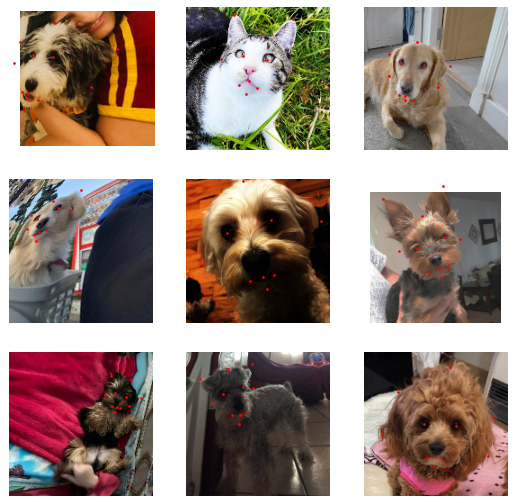

In [6]:
dls = dblock.dataloaders(images_path, bs=64)
dls.c = dls.train.after_item.c
dls.show_batch()

In [7]:
learn = cnn_learner(
    dls, 
    xresnet50, 
    loss_func=MSELossFlat(), 
    opt_func=ranger
).to_fp16()

In [12]:
learn.freeze_to(-1)

SuggestedLRs(lr_min=0.05248074531555176, lr_steep=0.0691830962896347)

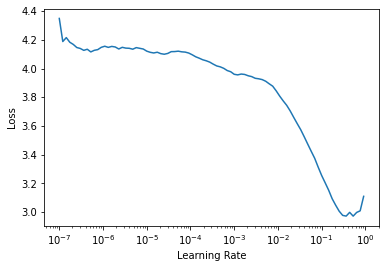

In [13]:
learn.lr_find()

In [14]:
learn.fit_flat_cos(
    5, 
    5e-2,
    wd=0.1,
    cbs=[
        SaveModelCallback()
    ]
)

epoch,train_loss,valid_loss,time
0,0.158847,0.093590,01:12
1,0.075371,0.062291,01:09
2,0.070828,0.050090,01:08
3,0.063797,0.046766,01:08
4,0.051518,0.036274,01:09


Better model found at epoch 0 with valid_loss value: 0.09359036386013031.
Better model found at epoch 1 with valid_loss value: 0.06229079142212868.
Better model found at epoch 2 with valid_loss value: 0.05009021237492561.
Better model found at epoch 3 with valid_loss value: 0.04676636680960655.
Better model found at epoch 4 with valid_loss value: 0.03627430275082588.


In [15]:
learn.unfreeze()

SuggestedLRs(lr_min=3.311311302240938e-05, lr_steep=7.585775847473997e-07)

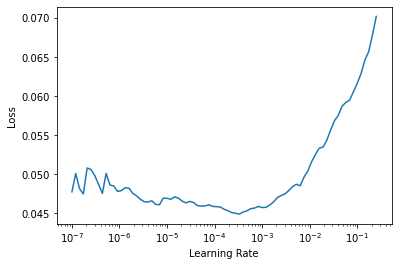

In [16]:
learn.lr_find()

epoch,train_loss,valid_loss,time
0,0.045194,0.039987,01:22
1,0.041134,0.055993,01:23
2,0.040432,0.038180,01:23
3,0.038160,0.034894,01:24
4,0.038161,0.029927,01:23
5,0.034662,0.030731,01:23
6,0.034100,0.031068,01:23
7,0.034346,0.030763,01:23
8,0.033012,0.026365,01:22
9,0.032622,0.025318,01:23


Better model found at epoch 0 with valid_loss value: 0.03998710960149765.


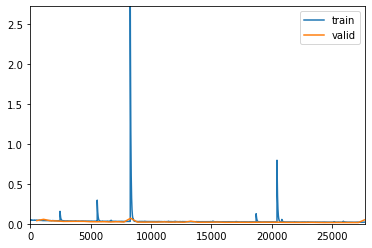

Better model found at epoch 2 with valid_loss value: 0.038180116564035416.
Better model found at epoch 3 with valid_loss value: 0.034893982112407684.
Better model found at epoch 4 with valid_loss value: 0.029927389696240425.
Better model found at epoch 8 with valid_loss value: 0.026365429162979126.
Better model found at epoch 9 with valid_loss value: 0.02531789429485798.
Better model found at epoch 11 with valid_loss value: 0.023139704018831253.
Better model found at epoch 13 with valid_loss value: 0.02226249687373638.
Better model found at epoch 15 with valid_loss value: 0.021583925932645798.
Better model found at epoch 16 with valid_loss value: 0.02089567668735981.
Better model found at epoch 20 with valid_loss value: 0.02052083984017372.
Better model found at epoch 22 with valid_loss value: 0.01992926560342312.
Better model found at epoch 24 with valid_loss value: 0.019777880981564522.
Better model found at epoch 28 with valid_loss value: 0.01886301301419735.
Better model found at e

In [17]:
learn.fit_flat_cos(
    50, 
    5e-5, 
    wd=0.1,
    cbs=[
        SaveModelCallback(), 
        ShowGraphCallback(),
        CSVLogger()
    ]
)

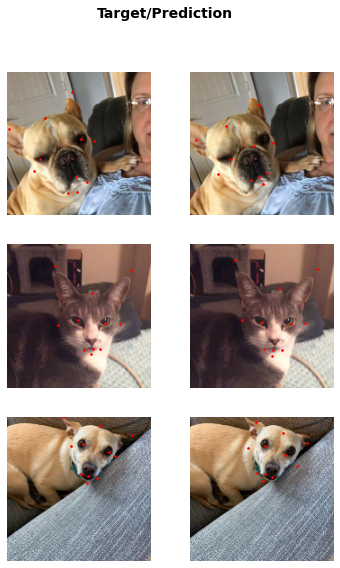

In [20]:
learn.show_results()

In [21]:
learn.export('../models/export.pkl')

In [22]:
### Deployement

In [1]:
from fastai2.basics import *
from fastai2.vision import *

In [2]:
def get_y_func(x):
    filename = str(x).split('/')[-1]
    zipped = zip(list(y.loc[filename])[0::2], list(y.loc[filename])[1::2])
    return tensor(list(zipped))

In [3]:
learn = load_learner('../models/export.pkl')

In [4]:
%%writefile pet_regression.py
from bentoml import BentoService, api, env, artifacts 
from bentoml.artifact import Fastai2ModelArtifact
from bentoml.adapters import FileInput
from fastai2.basics import *
from fastai2.vision import *

def get_y_func(x):
    filename = str(x).split('/')[-1]
    zipped = zip(list(y.loc[filename])[0::2], list(y.loc[filename])[1::2])
    return tensor(list(zipped))

@env(pip_dependencies=['gevent', 'fastai2'])
@artifacts([Fastai2ModelArtifact('pet_regressor')])
class PetRegression(BentoService):
    
    @api(FileInput)
    def predict(self, image):
        preds = self.artifacts.pet_regressor.predict(image)
        return preds

Overwriting pet_regression.py


In [5]:
from pet_regression import PetRegression
service = PetRegression()
service.pack('pet_regressor', learn)

[2020-08-09 16:01:46,854] WARNING - gevent package does not exist in the current python session
[2020-08-09 16:01:46,855] WARNING - BentoML by default does not include spacy and torchvision package when using Fastai2ModelArtifact. To make sure BentoML bundle those packages if they are required for your model, either import those packages in BentoService definition file or manually add them via `@env(pip_dependencies=['torchvision'])` when defining a BentoService


In [6]:
service.predict('/home/ec2-user/SageMaker/facial-features-detector/data/resized_and_user_images/Abyssinian_1.jpg')

(TensorPoint([[ 87.1824,  44.8654],
         [ 88.9352,  28.4029],
         [102.8567,  31.6101],
         [113.7130,  29.8774],
         [115.5062,  46.2101],
         [100.4494,  61.7966],
         [ 97.9865,  45.3176],
         [106.1615,  44.1829],
         [ 99.3559,  60.7229],
         [100.0580,  56.0602],
         [104.6155,  57.9496]]),
 tensor([ 0.0898, -0.4392,  0.1117, -0.6450,  0.2857, -0.6049,  0.4214, -0.6265,
          0.4438, -0.4224,  0.2556, -0.2275,  0.2248, -0.4335,  0.3270, -0.4477,
          0.2419, -0.2410,  0.2507, -0.2992,  0.3077, -0.2756]),
 tensor([ 0.0898, -0.4392,  0.1117, -0.6450,  0.2857, -0.6049,  0.4214, -0.6265,
          0.4438, -0.4224,  0.2556, -0.2275,  0.2248, -0.4335,  0.3270, -0.4477,
          0.2419, -0.2410,  0.2507, -0.2992,  0.3077, -0.2756]))

In [7]:
with remove_patches_path():  
    saved_path = service.save()

[2020-08-09 16:01:58,911] INFO - BentoService bundle 'PetRegression:20200809160157_0DEC93' saved to: /home/ec2-user/bentoml/repository/PetRegression/20200809160157_0DEC93


In [8]:
from bentoml import load
service = load(saved_path)

[2020-08-09 16:02:00,579] WARNING - Module `pet_regression` already loaded, using existing imported module.
[2020-08-09 16:02:01,279] WARNING - BentoML by default does not include spacy and torchvision package when using Fastai2ModelArtifact. To make sure BentoML bundle those packages if they are required for your model, either import those packages in BentoService definition file or manually add them via `@env(pip_dependencies=['torchvision'])` when defining a BentoService


In [9]:
saved_path

'/home/ec2-user/bentoml/repository/PetRegression/20200809160157_0DEC93'

In [10]:
f"{service.name}:{service.version}"

'PetRegression:20200809160157_0DEC93'

In [57]:
bentoml run predict /home/ec2-user/bentoml/repository/PetRegression/20200809160157_0DEC93 --input=/home/ec2-user/SageMaker/facial-features-detector/data/resized_and_user_images/Abyssinian_1.jpg

SyntaxError: invalid syntax (<ipython-input-57-73799aa0f73a>, line 1)

In [ ]:
bentoml serve /home/ec2-user/bentoml/repository/PetRegression/20200809160157_0DEC93